# Exploratory Data Analysis for B2AI Voice Dataset

*Goal is to explore acoustic and phenotype data to understand relationships linked to voice disorders.*

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [41]:
pd.set_option('display.max_columns', None)


Load the data

In [42]:
features = pd.read_csv('data/static_features.tsv', sep='\t')
labels = pd.read_csv('data/phenotype.tsv', sep='\t')

# Merge on participant_id
df = pd.merge(features, labels, on='participant_id', how='inner')
print(f"Merged dataset shape: {df.shape}")

Merged dataset shape: (19271, 1243)


In [43]:
print(labels.shape)

(442, 1109)


In [44]:
df

participant_id session_id_x                                  task_name  \
0           004d42e9     07031CC3                             Animal-fluency   
1           004d42e9     07031CC3                              Audio-Check-1   
2           004d42e9     3FDBC2E4                              Audio-Check-1   
3           004d42e9     07031CC3                              Audio-Check-2   
4           004d42e9     3FDBC2E4                              Audio-Check-2   
...              ...          ...                                        ...   
19266       ff75b163     6A3E7090        Respiration-and-cough-FiveBreaths-3   
19267       ff75b163     6A3E7090        Respiration-and-cough-FiveBreaths-4   
19268       ff75b163     6A3E7090  Respiration-and-cough-ThreeQuickBreaths-1   
19269       ff75b163     6A3E7090  Respiration-and-cough-ThreeQuickBreaths-2   
19270       ff75b163     6A3E7090                               Story-recall   

                                           transcription  \
0      Dogs, cats, lions, panthers, leopards, elephan...   
1                                       Testing 1, 2, 3.   
2                                Do you guys want to see   
3      I am happy to participate in the Bridge 2A1 st...   
4                                                      .   
...                                                  ...   
19266  I was going to tell you all, Galilee. Other th...   
19267                                                  .   
19268                                                 Oh   
19269                                                 Oh   
19270  Grandfather was about 93 years old. He had a l...   

       F0semitoneFrom27.5Hz_sma3nz_amean  \
0                              30.849073   
1                              34.568218   
2                              41.191250   
3                              32.003578   
4                              52.785332   
...                                  ...   
19266                          30.285301   
19267                           0.000000   
19268                           0.000000   
19269                           0.000000   
19270                          25.704922   

       F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                                    0.205649   
1                                    0.029504   
2                                    0.150530   
3                                    0.173312   
4                                    0.000343   
...                                       ...   
19266                                0.161516   
19267                                0.000000   
19268                                0.000000   
19269                                0.000000   
19270                                0.102639   

       F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                       26.938833   
1                                       33.598133   
2                                       36.817909   
3                                       31.437626   
4                                       52.771900   
...                                           ...   
19266                                   22.592297   
19267                                    0.000000   
19268                                    0.000000   
19269                                    0.000000   
19270                                   24.731934   

       F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                       32.299248   
1                                       34.758118   
2                                       38.173531   
3                                       32.997253   
4                                       52.784058   
...                                           ...   
19266                                   32.917130   
19267                                    0.000000   
19268                                    0.000000   
19269                                  

In [45]:
# 2. Create voice disorder label
voice_disorder_cols = ['laryng_cancer', 'benign_cord_lesion', 'rrp', 'spas_dys', 'voc_fold_paralysis']
for col in voice_disorder_cols:
    if col not in df.columns:
        print(f"Warning: column {col} not found.")
df['voice_disorder'] = 0

df['voice_disorder'] = (
    df[voice_disorder_cols].eq("Checked")   # True where entry == "Checked"
      .any(axis=1)                          # any disorder flagged
      .astype(int)
)

print(df['voice_disorder'].value_counts())
print(df['voice_disorder'].value_counts(normalize=True))



voice_disorder
0    13937
1     5334
Name: count, dtype: int64
voice_disorder
0    0.723211
1    0.276789
Name: proportion, dtype: float64


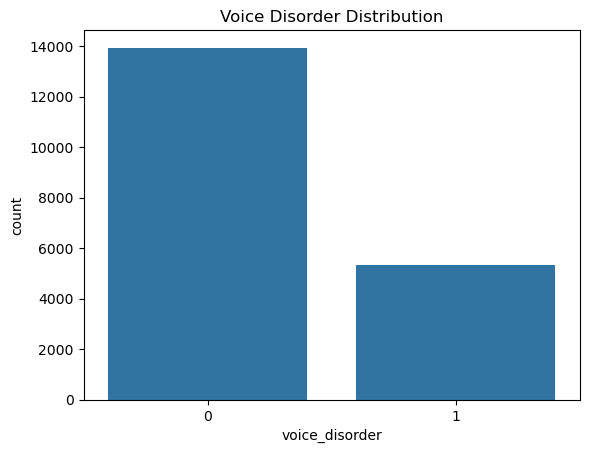

In [46]:
# 3. Inspect target distribution
sns.countplot(x='voice_disorder', data=df)
plt.title('Voice Disorder Distribution')
plt.show()


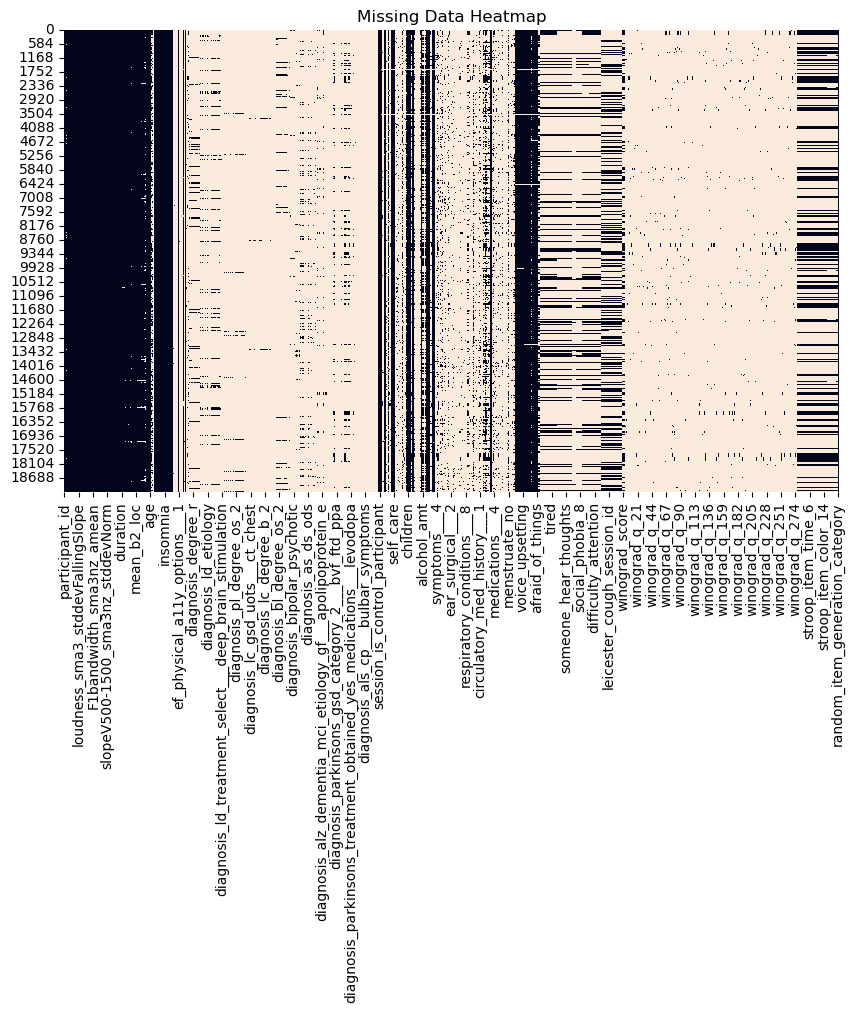

In [47]:
# 4. Missing data overview
plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cbar=False)
plt.title('Missing Data Heatmap')
plt.show()

In [48]:
print(df.describe().T)

                                              count        mean        std  \
F0semitoneFrom27.5Hz_sma3nz_amean           19271.0   26.101295  13.225603   
F0semitoneFrom27.5Hz_sma3nz_stddevNorm      19271.0    0.094062   0.090613   
F0semitoneFrom27.5Hz_sma3nz_percentile20.0  19271.0   24.036883  12.414680   
F0semitoneFrom27.5Hz_sma3nz_percentile50.0  19271.0   26.197125  13.489960   
F0semitoneFrom27.5Hz_sma3nz_percentile80.0  19271.0   28.197189  14.580775   
...                                             ...         ...        ...   
vocabulary_item_difficulty_4                 6343.0    2.000000   0.000000   
vocabulary_item_difficulty_5                 6343.0    3.000000   0.000000   
vocabulary_item_difficulty_6                 6343.0    3.000000   0.000000   
random_duration                              6560.0  113.375610  58.916326   
voice_disorder                              19271.0    0.276789   0.447423   

                                             min        25%    

In [49]:
# 6. Correlation heatmap for acoustic features
phenotype_cols_to_exclude = list(labels.columns)
other_cols_to_exclude = ['session_id', 'voice_disorder', 'task_name', 'transcription']
all_exclusions = phenotype_cols_to_exclude + other_cols_to_exclude
acoustic_cols = [col for col in df.columns if col not in all_exclusions]
acoustic_cols
# plt.figure(figsize=(12,8))
# sns.heatmap(df[acoustic_cols].corr().abs(), cmap='coolwarm', center=0, cbar_kws={'shrink':.8})
# plt.title('Feature Correlation Heatmap')
# plt.show()

['session_id_x',
 'F0semitoneFrom27.5Hz_sma3nz_amean',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'loudness_sma3_amean',
 'loudness_sma3_stddevNorm',
 'loudness_sma3_percentile20.0',
 'loudness_sma3_percentile50.0',
 'loudness_sma3_percentile80.0',
 'loudness_sma3_pctlrange0-2',
 'loudness_sma3_meanRisingSlope',
 'loudness_sma3_stddevRisingSlope',
 'loudness_sma3_meanFallingSlope',
 'loudness_sma3_stddevFallingSlope',
 'spectralFlux_sma3_amean',
 'spectralFlux_sma3_stddevNorm',
 'mfcc1_sma3_amean',
 'mfcc1_sma3_stddevNorm',
 'mfcc2_sma3_amean',
 'mfcc2_sma3_stddevNorm',
 'mfcc3_sma3_amean',
 'mfcc3_sma3_stdd

In [50]:
df[acoustic_cols].shape

(19271, 133)

In [51]:
phenotype_cols_to_exclude

['participant_id',
 'redcap_repeat_instrument',
 'redcap_repeat_instance',
 'selected_language',
 'age',
 'eligible_studies___1',
 'eligible_studies___2',
 'eligible_studies___3',
 'eligible_studies___4',
 'eligible_studies___5',
 'is_control_participant',
 'laryng_cancer',
 'benign_cord_lesion',
 'rrp',
 'spas_dys',
 'voc_fold_paralysis',
 'alz_dementia_mci',
 'als',
 'parkinsons',
 'alcohol_subst_abuse',
 'gad',
 'add_adhd',
 'asd',
 'bipolar',
 'bpd',
 'depression',
 'ed',
 'insomnia',
 'ocd',
 'panic',
 'ptsd',
 'schizophrenia',
 'soc_anx_dis',
 'other_psych',
 'asthma',
 'airway_stenosis',
 'chronic_cough',
 'copd',
 'osa',
 'ef_select_language',
 'ef_any_vision_related_req',
 'ef_vision_a11y_options___1',
 'ef_vision_a11y_options___2',
 'ef_vision_a11y_options___3',
 'ef_vision_a11y_options___4',
 'ef_any_hearing_related_req',
 'ef_hearing_a11y_options___1',
 'ef_hearing_a11y_options___2',
 'ef_hearing_a11y_options___3',
 'ef_any_physical_challenges',
 'ef_physical_a11y_options__

## PCA

I'll instead use Zack's PCA because it's based on the cleaned version of the data

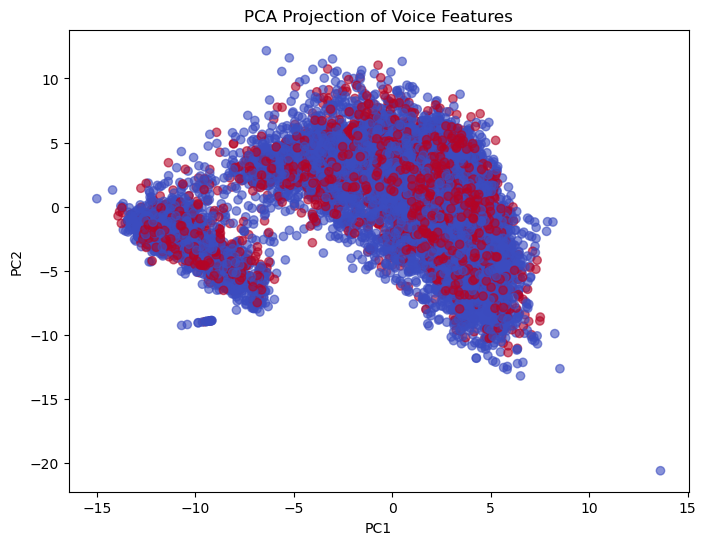

Explained variance ratio: [0.2068111 0.0800418]


In [58]:
# 7. PCA visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[acoustic_cols].select_dtypes(include=np.number).fillna(0))
y = df['voice_disorder']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection of Voice Features')
plt.show()

print('Explained variance ratio:', pca.explained_variance_ratio_)

Key feature selection
Gonna go with the following features.
- mean_f0_hertz, 
- jitterLocal_sma3nz_amean, 
- shimmerLocaldB_sma3nz_amean, 
- HNRdBACF_sma3nz_amean
because they supposed be actual indicators of disorders. Voice science.

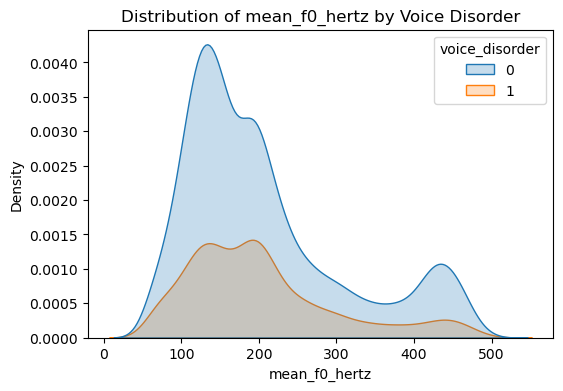

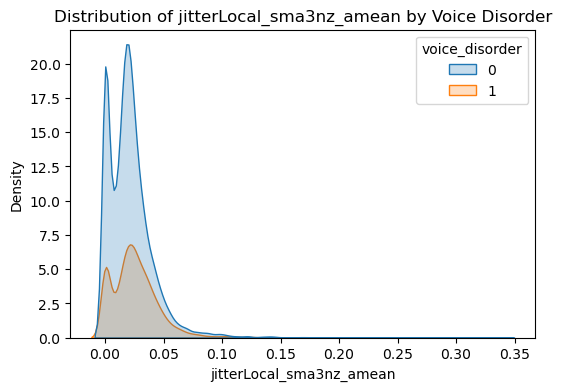

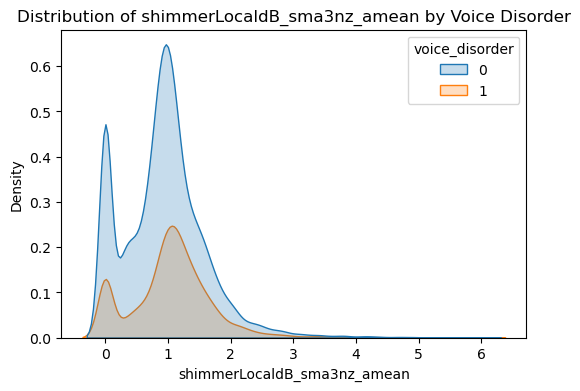

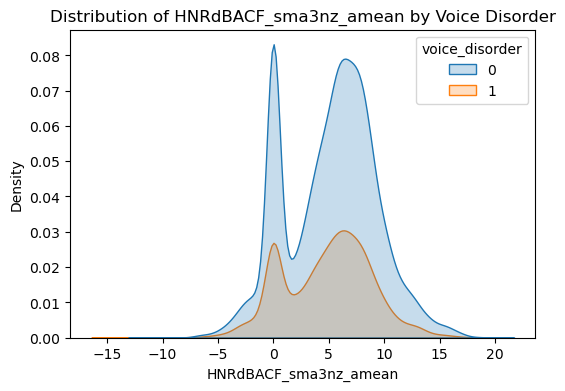

In [59]:
# 8. Key feature comparisons
key_features = ['mean_f0_hertz', 'jitterLocal_sma3nz_amean', 'shimmerLocaldB_sma3nz_amean', 'HNRdBACF_sma3nz_amean']

for feat in key_features:
    if feat in df.columns:
        plt.figure(figsize=(6,4))
        sns.kdeplot(data=df, x=feat, hue='voice_disorder', fill=True)
        plt.title(f'Distribution of {feat} by Voice Disorder')
        plt.show()
    else:
        print(f"Feature {feat} not found.")

Shape of X_clean: (15926, 131)
Shape of y_clean: (15926,)


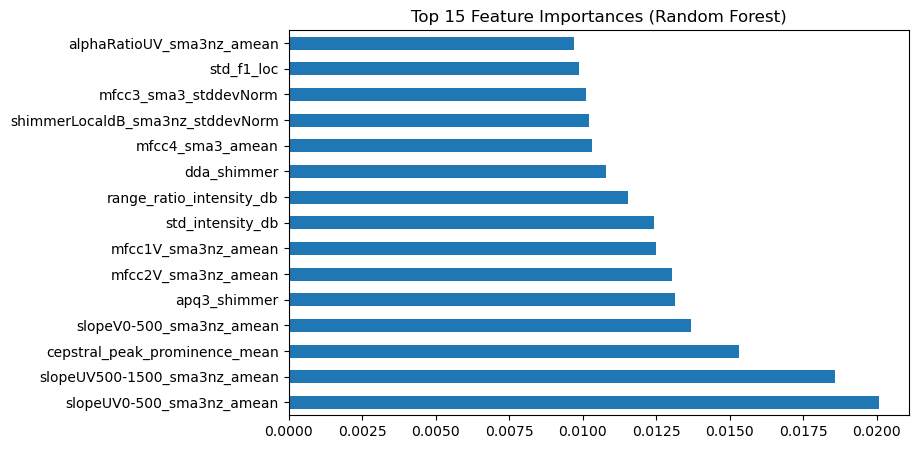

In [75]:
# 9. Feature importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Create a clean dataframe by dropping rows with missing values in acoustic features
clean_df = df.dropna(subset=acoustic_cols)

# Now, define X_clean and y_clean from this clean dataframe
# This ensures X and y are perfectly aligned
X_clean = clean_df[acoustic_cols].select_dtypes(include=np.number)
y_clean = clean_df['voice_disorder']

print(f"Shape of X_clean: {X_clean.shape}")
print(f"Shape of y_clean: {y_clean.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X_clean.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,5))
importances.plot(kind='barh')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

Are our 4 chosen features part of this set?
Why or why not?

Clean data using Zack's clean data set so that things are all uniform

# Import Zack's data set and Normalise

In [68]:
# Load Zack's clean data set
import pickle 

with open("data/X_clean.pkl", 'rb') as file:
    X = pickle.load(file)
with open("data/y_clean.pkl", 'rb') as file:
    y = pickle.load(file)
with open("data/groups.pkl", 'rb') as file:
    groups = pickle.load(file)
    
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_proc = ss.fit_transform(X)

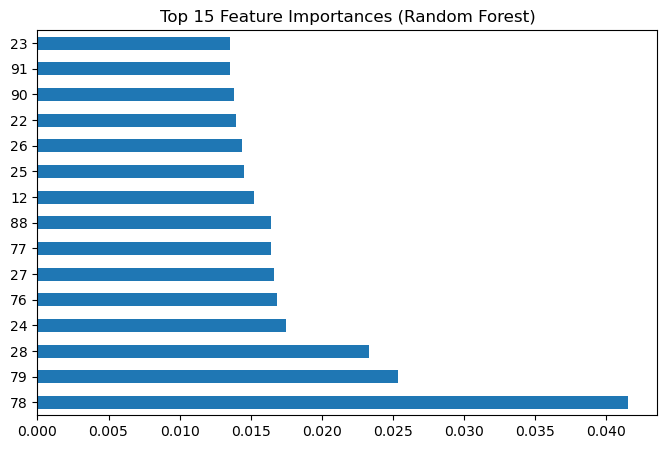

In [70]:
# 9. Feature importance, but I need to clean the data set
# Create a clean dataframe by dropping rows with missing values in acoustic features

X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,5))
importances.plot(kind='barh')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()
